# Object Detection - Quick Start

:label:`sec_object_detection_quick`


Object detection is the process of identifying and localizing objects in an image and is an important task in computer vision. Follow this tutorial to learn how to use AutoGluon for object detection.

**Tip**: If you are new to AutoGluon, review :ref:`sec_imgquick` first to learn the basics of the AutoGluon API.

Our goal is to detect motorbike in images by [YOLO3 model](https://pjreddie.com/media/files/papers/YOLOv3.pdf). A tiny dataset is collected from VOC dataset, which only contains the motorbike category. The model pretrained on the COCO dataset is used to fine-tune our small dataset. With the help of AutoGluon, we are able to try many models with different hyperparameters automatically, and return the best one as our final model. 

To start, import autogluon and ObjectDetection module as your task:

In [1]:
import autogluon as ag
from autogluon import ObjectDetection as task

## Tiny_motorbike Dataset
We collect a toy dataset for detecting motorbikes in images. From the VOC dataset, images are randomly selected for training, validation, and testing - 120 images for training, 50 images for validation, and 50 for testing. This tiny dataset follows the same format as VOC. 

Using the commands below, we can download this dataset, which is only 23M. The variable `root` specifies the path to store the dataset in. The name of unzipped folder is called `tiny_motorbike`.

In [2]:
root = './'
filename_zip = ag.download('https://autogluon.s3.amazonaws.com/datasets/tiny_motorbike.zip',
                        path=root)
filename = ag.unzip(filename_zip, root=root)

When we retrieve the dataset, we can create a dataset instance with its path and classes if it is a custom dataset.

In [3]:
import os
data_root = os.path.join(root, filename)
dataset_train = task.Dataset(data_root, classes=('motorbike',))

>>> create dataset(VOC format) 


## Fit Models by AutoGluon
In this section, we demonstrate how to apply AutoGluon to fit our detection models. We use mobilenet as the backbone for the YOLO3 model. Two different learning rates are used to fine-tune the network. The best model is the one that obtains the best performance on the validation dataset. You can also try using more networks and hyperparameters to create a larger searching space. 

We `fit` a classifier using AutoGluon as follows. In each experiment (one trial in our searching space), we train the model for 30 epoches.

Starting Experiments
Num of Finished Tasks is 0
Num of Pending Tasks is 2


scheduler: FIFOScheduler(
DistributedResourceManager{
(Remote: Remote REMOTE_ID: 0, 
	<Remote: 'inproc://172.16.86.165/12425/1' processes=1 threads=32, memory=257.79 GB>, Resource: NodeResourceManager(32 CPUs, 4 GPUs))
})



{'dataset': <autogluon.task.object_detection.dataset.voc.CustomVOCDetection object at 0x7f5974d47f50>, 'net': 'mobilenet1.0', 'lr': 0.0005, 'loss': SoftmaxCrossEntropyLoss(batch_axis=0, w=None), 'num_gpus': 1, 'batch_size': 16, 'split_ratio': 0.8, 'epochs': 30, 'num_workers': 12, 'hybridize': True, 'verbose': False, 'final_fit': False, 'seed': 223, 'data_shape': 416, 'start_epoch': 0, 'transfer': 'coco', 'lr_mode': 'step', 'lr_decay': 0.1, 'lr_decay_period': 0, 'lr_decay_epoch': '160,180', 'warmup_lr': 0.0, 'warmup_epochs': 2, 'momentum': 0.9, 'wd': 0.0005, 'log_interval': 100, 'save_prefix': 'yolo3_mobilenet1.0_custom', 'save_interval': 10, 'val_interval': 1, 'num_samples': -1, 'no_random_shape': False, 'no_wd': False, 'mixup': False, 'no_mixup_epochs': 20, 'label_smooth': False, 'resume': '', 'syncbn': False, 'reuse_pred_weights': True, 'task_id': 0}
{'dataset': <autogluon.task.object_detection.dataset.voc.CustomVOCDetection object at 0x7f597783d990>, 'net': 'mobilenet1.0', 'lr': 0.0

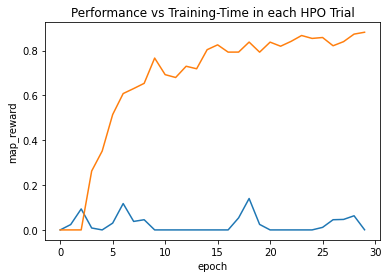

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> finish model fitting
The best config: {'lr.choice': 1, 'net.choice': 0}


In [4]:
time_limits = 5*60*60  # 5 hours
epochs = 30
detector = task.fit(dataset_train,
                    num_trials=2,
                    epochs=epochs,
                    lr=ag.Categorical(5e-4, 1e-4),
                    ngpus_per_trial=1,
                    time_limits=time_limits)

After fitting, AutoGluon automatically returns the best model among all models in the searching space. From the output, we know the best model is the one trained with the second learning rate. To see how well the returned model performed on test dataset, call detector.evaluate().

In [5]:
dataset_test = task.Dataset(data_root, index_file_name='test', classes=('motorbike',))

test_map = detector.evaluate(dataset_test)
print("mAP on test dataset: {}".format(test_map[1][1]))

>>> create dataset(VOC format) 


mAP on test dataset: 0.8332329769299963


Below, we randomly select an image from test dataset and show the predicted box and probability over the origin image.

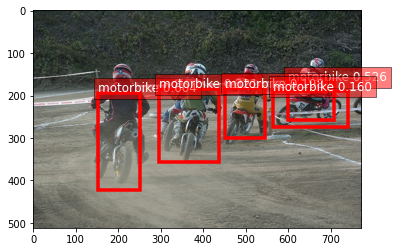

In [6]:
image = '000467.jpg'
image_path = os.path.join(data_root, 'JPEGImages', image)

ind, prob, loc = detector.predict(image_path)